Import the needed packages and ml modules 

In [2]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

# import folium
# import folium.plugins
# import pandas as pd
# import xarray as xr
# import branca
# import branca.colormap as cm

Quick check of a data sample

7.8006134033203125


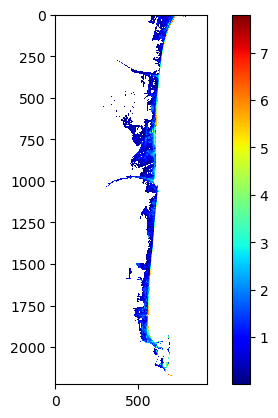

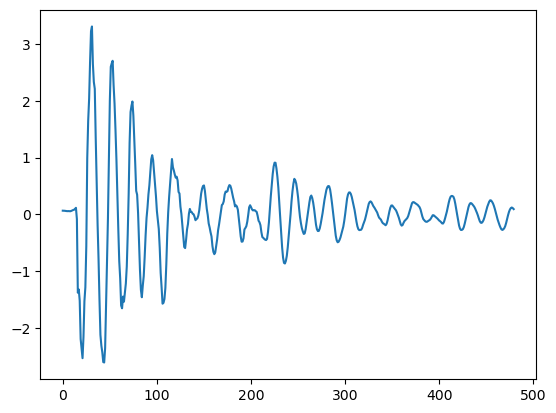

-0.06637674570083618
-0.38681620359420776


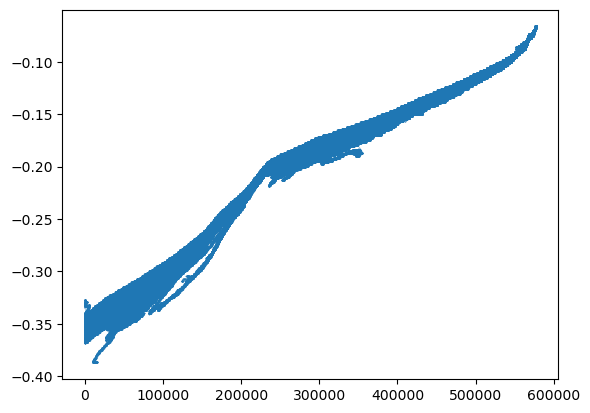

In [39]:
# d_array  = np.load('../data/processed/d_SR.npy')
# t_array  = np.load('../data/processed/t_SR.npy')

d_array = np.memmap('../../data/processed/d_CT_900.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 2224, 912))

t_array = np.memmap('../../data/processed/t_CT_900.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 9, 480))

red_d_array = np.memmap('../../data/processed/dZflat_CT_900.dat',
                         mode='r+',
                         dtype=float,
                         shape=(1197, 577001))


data = d_array[492,:,:]
data = np.ma.masked_where(data == 0, data)
print(data.max())
plt.imshow(data, cmap='jet',interpolation='none')
plt.colorbar()
plt.show()

data_t = t_array[492,0,:]
plt.plot(data_t)
plt.show()

data_flat = red_d_array[492,:]
print(data_flat.max())
print(max(data_flat.min(), data_flat.max(), key=abs))
plt.scatter(np.arange(len(data_flat)), data_flat, s=0.1)
plt.show()



In [10]:
np.random.seed(0)
torch.random.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Autoencoder model for onshore time series

In [10]:
import model_utils as utils

In [11]:
reg = 'CT'
# red_d_array = red_d_array[:,:50000]

# input data
data = red_d_array[:int(len(red_d_array)*0.65),:]
test_data = red_d_array[int(len(red_d_array)*0.65):,:]

# y = data.shape[1] 
# x = data.shape[2]

xy= data.shape[1] # non zero grids
batch_size = 20
num_epochs = 3000
learning_rate = 0.00005
num_folds = 0

test_zlist = [[64,64]]

# train model and save loss info to file
# for zlist in test_zlist:
#     trainAE(num_folds,batch_size,num_epochs,learning_rate,xy,zlist)


In [13]:
zlist = [64,64]
model = torch.load(f"./../../model/{reg}/out/model_deform_ch_[64, 64]_minepoch_900.pt", map_location=torch.device('cpu')) #/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/model_deform_ch_[64, 64]_minepoch_900.pt
#read model from file for testing


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]      36,928,128
         LeakyReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
         LeakyReLU-6                   [-1, 64]               0
            Linear-7               [-1, 577001]      37,505,065
         LeakyReLU-8               [-1, 577001]               0
Total params: 74,441,513
Trainable params: 74,441,513
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.20
Forward/backward pass size (MB): 8.81
Params size (MB): 283.97
Estimated Total Size (MB): 294.98
----------------------------------------------------------------
test loss: 0.03078


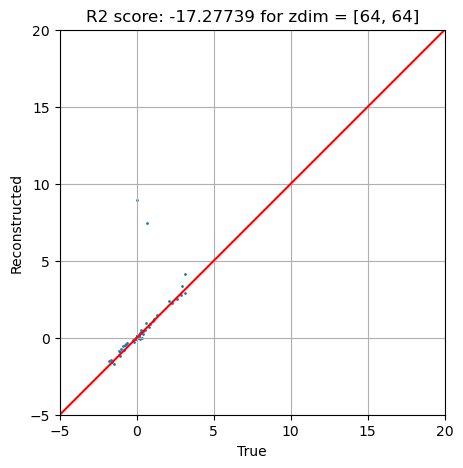

In [15]:
summary(model,(xy,))
model.eval()
# Test model for final evaluation
predic = np.zeros(test_data.shape)
criterion = nn.MSELoss()                
# Test model
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_data))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    test_loss = 0
    for batch_idx, (batch_data,) in enumerate(test_loader):
        # batch_data = batch_data.to('cuda')
        recon_data = model(batch_data)
        loss = criterion(recon_data, batch_data)
        test_loss += loss.item()
        predic[batch_idx*batch_size:(batch_idx+1)*batch_size] = recon_data.cpu().numpy()
    print(f"test loss: {test_loss / len(test_loader):.5f}")

# Plot results max height for all events
test_max = np.max(test_data,axis=(1))
recon_max = np.max(predic,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {zlist}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
# plt.savefig(f"./../../model/{reg}/plot/onshore_test_z_{zlist}.png")   
plt.show()


In [18]:
all_ids = np.loadtxt('../../data/events/shuffled_events_CT_900.txt', dtype='str',skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../../resources/processed/allinfo_eventsBS_PS53550.txt', sep=',')

#check performance per event
eve_perf = []
for eve_no,eve in enumerate(test_ids):
    eve_perf.append([eve_no,
                     r2_score(test_data[eve_no,:], predic[eve_no,:]),
                     mean_squared_error(test_data[eve_no,:],predic[eve_no,:])])

#count of events less than 
eve_perf = np.array(eve_perf)
print(eve_perf[eve_perf[:,1]<0.9].shape[0])
print(eve_perf[eve_perf[:,1]<0.9])

/tmp/ipykernel_2469929/3494820867.py:3: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  eve_info = pd.read_csv('../../resources/processed/allinfo_eventsBS_PS53550.txt', sep=',')


299
[[ 1.00000000e+00  3.70586336e-01  4.19394618e-04]
 [ 2.00000000e+00  5.65688838e-01  1.15503784e+00]
 [ 3.00000000e+00  7.82755722e-01  9.31365848e-03]
 [ 4.00000000e+00  0.00000000e+00  8.70980520e-06]
 [ 6.00000000e+00 -9.86512307e+00  1.56440007e-05]
 [ 7.00000000e+00 -2.09737264e+02  8.74704148e-05]
 [ 8.00000000e+00  0.00000000e+00  8.70980520e-06]
 [ 9.00000000e+00  6.62199356e-01  9.76128768e-02]
 [ 1.00000000e+01 -1.59780210e+02  1.46776220e-05]
 [ 1.10000000e+01  7.67321283e-01  2.84641182e-04]
 [ 1.20000000e+01 -2.11399994e+00  4.71428953e-05]
 [ 1.30000000e+01  4.40743059e-01  7.75457418e-05]
 [ 1.40000000e+01  1.09025051e-01  3.97668453e-01]
 [ 1.60000000e+01  8.34894070e-01  5.06627216e-02]
 [ 1.70000000e+01  3.59479590e-01  2.83161501e-04]
 [ 1.80000000e+01  8.49640782e-01  3.46894129e-06]
 [ 1.90000000e+01  8.08512210e-01  3.36930614e-03]
 [ 2.00000000e+01  8.46854560e-01  6.10156349e-03]
 [ 2.20000000e+01  7.26070636e-01  9.24374409e-03]
 [ 2.30000000e+01 -1.337534

test_05: 577001, recon_05: 577001
0.9154236912727356 2.7966063022613525


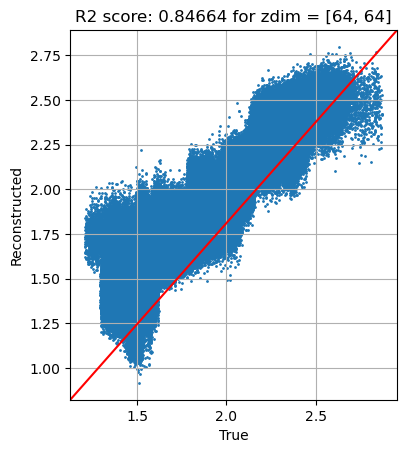

In [34]:
#93,200,139,267,314
eve_no = 100 
eve = test_ids[eve_no]
#count number of grids with max height > 0.5
test_05 = np.count_nonzero(test_data[eve_no, :] > 0.005)
recon_05 = np.count_nonzero(predic[eve_no, :] > 0.005)
print(f"test_05: {test_05}, recon_05: {recon_05}")
# Plot results max depth and error for one event with basemap around sicily
#grid map
error2fill = np.zeros(d_array.shape[1:])
depth2fill = np.zeros(d_array.shape[1:])

print(min(predic[eve_no,:]),max(predic[eve_no,:]))

zero_mask = np.load('../../data/processed/zero_mask_CT_900.npy')
error2fill[~zero_mask] = test_data[eve_no, :] - predic[eve_no, :]
depth2fill[~zero_mask] = predic[eve_no,:]

plt.scatter(test_data[eve_no,:], predic[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_data[eve_no,:], predic[eve_no,:]):.5f} for zdim = {zlist}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')

plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()
